In [1]:
from urllib.request import urlopen
from PIL import Image

puppy_path = "https://th.bing.com/th/id/R.240cb7f85d061f3fba9763885de45bc0?rik=mpqKenOb192tow&riu=http%3a%2f%2fwww.whoa.in%2f201604-Whoa%2fcute-puppy-pictures-images-hd.jpg&ehk=GBPH8TwRimIWYj%2fVuIY9ZqLQogOztpl2iyLb0P3UM%2fA%3d&risl=&pid=ImgRaw&r=0"

image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the grass"


## Streps

* A tokenizer for tokenizing the textual input
* A preprocessor to preprocess and resize the image
* The main model that converts the previous outputs to embedding

In [2]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [3]:
# Tokenize our input
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  5922, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [4]:
# Convert our input back to tokens
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'grass</w>',
 '<|endoftext|>']

In [5]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [6]:
# Preprocess image
processed_image = clip_processor(text=None, images=image, return_tensors="pt")["pixel_values"]
processed_image.shape


torch.Size([1, 3, 224, 224])

In [7]:
processed_image.squeeze().shape

torch.Size([3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

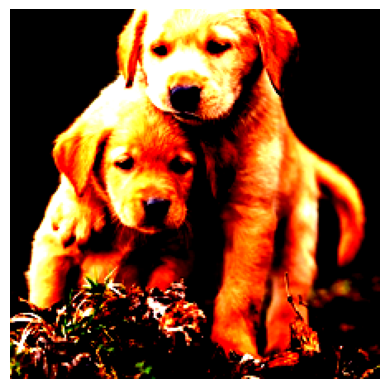

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Prepare image for visualization
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis("off")

In [15]:
# Create the image embedding
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [16]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = np.dot(text_embedding, image_embedding.T)
score

AttributeError: 'numpy.ndarray' object has no attribute 'norm'

In [17]:
score

array([[0.26447594]], dtype=float32)

In [19]:
from sentence_transformers import SentenceTransformer, util

# Load SBERT-compatible CLIP model
model = SentenceTransformer("clip-ViT-B-32")

# Encode the images
image_embeddings = model.encode(images)

# Encode the captions
text_embeddings = model.encode(captions)

#Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

NameError: name 'images' is not defined

## Preprocess multimodel inputs

In [2]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load processor and main model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16)

# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
  )
  (qf

## Tip
Using model.vision_model and model.language_model, we can see which

ViT and generative model are used, respectively, in the BLIP-2 model we loaded.

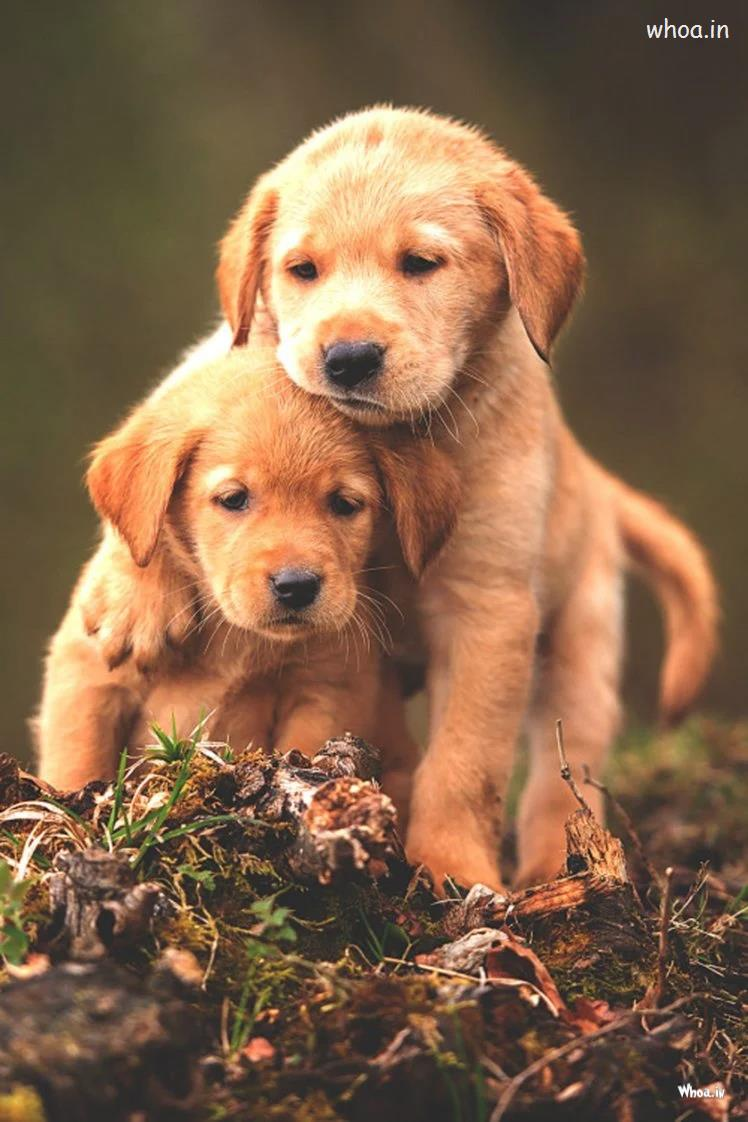

In [4]:

from urllib.request import urlopen
from PIL import Image

# Load image of a supercar
car_path = "https://th.bing.com/th/id/R.240cb7f85d061f3fba9763885de45bc0?rik=mpqKenOb192tow&riu=http%3a%2f%2fwww.whoa.in%2f201604-Whoa%2fcute-puppy-pictures-images-hd.jpg&ehk=GBPH8TwRimIWYj%2fVuIY9ZqLQogOztpl2iyLb0P3UM%2fA%3d&risl=&pid=ImgRaw&r=0"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [6]:
# Preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device,
torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [7]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [8]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]
# Convert input ids back to tokens
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

In [9]:
# Replace the space token with an underscore
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 '_vocal',
 'ization',
 '_was',
 '_remarkably',
 '_mel',
 'odic']

## Image Captioning

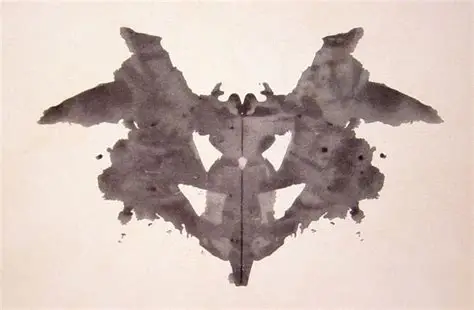

In [16]:
# Load an AI-generated image of a supercar
image_path = "https://tse3.mm.bing.net/th/id/OIP.EcOFfwVgoNETvL6zKX0dUAHaE2?rs=1&pid=ImgDetMain&o=7&rm=3"
image = Image.open(urlopen(image_path)).convert("RGB")
# Convert an image into inputs and preprocess it
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
image

In [17]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=50)

# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text


'a black and white image of a bat'

In [18]:
# Load Rorschach image


image = Image.open(urlopen(image_path)).convert("RGB")
# Generate caption
inputs = blip_processor(image, return_tensors="pt").to(device,
torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(
generated_ids, skip_special_tokens=
True
)
generated_text = generated_text[0].strip()
generated_text


'a black and white image of a bat'

## Use Case 2: Multimodal Chat-Based Prompting

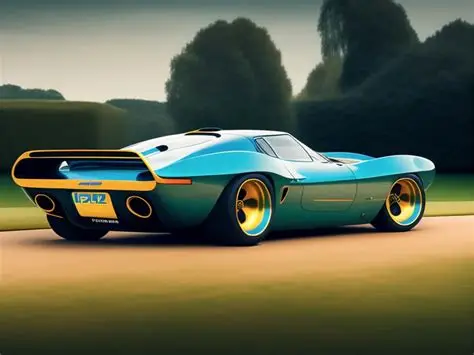

In [20]:
# Load an AI-generated image of a supercar
car_path = "https://tse2.mm.bing.net/th/id/OIP.r09olb8CCJpPA1hbLIFkGgHaFj?rs=1&pid=ImgDetMain&o=7&rm=3"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [24]:
# Visual question answering
prompt = "Question: Write down what you see in this picture. Answer:"

# Process both the image and the prompt
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# Generate text
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. \n Answer: A blue sports car with yellow rims'

In [25]:
# Chat-like prompting
prompt = """Question: Write down what you see in this picture.
Answer: A blue sports car with yellow rims. Question:
What would it cost me to drive that car? Answer:"""
# Generate output
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text


'Question: Write down what you see in this picture. \nAnswer: A blue sports car with yellow rims. Question: \nWhat would it cost me to drive that car? Answer: $1,000,000'

In [34]:
from IPython.display import HTML, display
import ipywidgets as widgets
import torch

def text_eventhandler(*args):
    question = args[0]["new"]

    if question:
        # Clear the input box
        args[0]["owner"].value = ""

        # Create prompt based on memory (history)
        if not memory:
            prompt = " Question: " + question + " Answer:"
        else:
            template = "Question: {} Answer: {}."
            prompt = " ".join(
                [
                    template.format(memory[i][0], memory[i][1])
                    for i in range(len(memory))
                ]
            ) + " Question: " + question + " Answer:"

        # Generate text
        # Note: Ensure 'blip_processor', 'image', 'model', and 'device' are defined in previous cells
        inputs = blip_processor(image, text=prompt, return_tensors="pt")
        inputs = inputs.to(device, torch.float16)

        generated_ids = model.generate(**inputs, max_new_tokens=100)
        generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)

        # Clean up the generated text
        generated_text = generated_text[0].strip().split("Question")[0]

        # Update memory
        memory.append((question, generated_text))

        # Assign to output widget
        output.append_display_data(HTML("<b>USER:</b> " + question))
        output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
        output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text(placeholder='Ask a question about the image...')
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")

output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)